# DAb-seq Analysis Example - 3 Cell Experiment
Ben Demaree - 2020

Three cell lines (Jurkat, Raji, K562) were encapsulated at roughly equal proportions on the Tapestri and processed according to the DAb-seq protocol.

*Note: generate input data using DAb-seq pipeline: https://github.com/AbateLab/DAb-seq*

In [1]:
# imports
from __future__ import division
import itertools
import math
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
#plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False
from sklearn.manifold import TSNE
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import os
from IPython.display import display, HTML
from scipy.stats.mstats import gmean
from matplotlib.ticker import NullFormatter
from scipy.stats import binned_statistic
from IPython.display import display, HTML, Image
import loompy
import h5py
import copy
import umap
from statannot import add_stat_annotation
matplotlib.rc('font', family='Helvetica')
import os

In [2]:
# class definitions and functions for analyzing single-cell data
# for single experimental cohorts (one hdf5 file per cohort)

def load_genotypes(hdf5_path):
    # load genotyping data from hdf5-compressed file
    
    # load in genotyping calls
    cell_barcodes = [c.decode('utf8') for c in h5py.File(hdf5_path)['CELL_BARCODES']]
    variants = [v.decode('utf8') for v in h5py.File(hdf5_path)['VARIANTS']]
    
    genotypes = pd.DataFrame(np.array(h5py.File(hdf5_path)['GT']), index=cell_barcodes, columns=variants)
    quality = pd.DataFrame(np.array(h5py.File(hdf5_path)['GQ']), index=cell_barcodes, columns=variants)
    total_depth = pd.DataFrame(np.array(h5py.File(hdf5_path)['DP']), index=cell_barcodes, columns=variants)
    alt_depth = pd.DataFrame(np.array(h5py.File(hdf5_path)['AD']), index=cell_barcodes, columns=variants)
        
    # calculate single-cell vafs - NaN for division by 0
    vaf = np.divide(alt_depth, total_depth)
    
    # load in amplicon counts
    amplicons = [a.decode('utf8') for a in h5py.File(hdf5_path)['AMPLICONS/NAMES']]
    amplicon_counts = pd.DataFrame(h5py.File(hdf5_path)['AMPLICONS/COUNTS'], index=cell_barcodes, columns=amplicons)
    amplicon_counts.index.name = 'cell_barcode'
        
    return cell_barcodes, genotypes, quality, total_depth, alt_depth, vaf, amplicon_counts

def load_abs(hdf5_path, count_method):
    # load ab count data
    
    ab_names = [a.decode('utf8') for a in h5py.File(hdf5_path)['AB_DESCRIPTIONS']]
    ab_counts = pd.DataFrame(h5py.File(hdf5_path)['ABS/%s' % count_method], index=cell_barcodes, columns=ab_names)
    ab_counts.index.name = 'cell_barcode'
    
    return ab_counts    

def filter_variants(genotypes,
                    alt_depth,
                    total_depth,
                    quality,
                    min_alt_depth,
                    min_total_depth,
                    min_quality):
    # filters variants from genotyping data based on simple metrics

    genotypes[total_depth < min_total_depth] = 3
    genotypes[((genotypes == 1) | (genotypes == 2)) & (alt_depth < min_alt_depth)] = 3
    genotypes[quality < min_quality] = 3
    genotypes[genotypes.isnull()] = 3
    
    # replace GT entries for FLT3-ITD
    # quality = 0 for ITD implies WT
    genotypes_flt3 = genotypes.loc[:, genotypes.filter(like='FLT3-ITD', axis=1).columns]
    quality_flt3 = quality.loc[:, quality.filter(like='FLT3-ITD', axis=1).columns]
    
    genotypes_flt3[quality_flt3 == 0] = 0
    genotypes.loc[:, genotypes.filter(like='FLT3-ITD', axis=1).columns] = genotypes_flt3

    return genotypes

def load_variants(variants_file_path):
    # load variant annotations tsv file
    variant_info = pd.read_csv(variants_file_path, sep='\t', header=0, index_col='Name', low_memory=False)
    variant_info.index.name = 'variant' 
    
    return variant_info
    
class DabseqSample(object):
    # class for storing experimental data from a dabseq sample
    # one cohort may be comprised of one or more samples
    
    def __init__(self,
                 sample_name):
        
            # sample metadata
            self.sample_name = sample_name

            # data structures for single-cell data
            self.n_cells = None                     # number of cells in experiment
            self.barcodes = None                    # list of barcode sequences

            self.genotypes = None                   # array of genotypes for this experiment

            self.number_genotyped = None            # per-variant number of cells genotyped
            self.fraction_genotyped = None          # per-variant fraction cells with called genotypes 

            self.number_genotyped = None            # per-variant number of cells mutated (HET or HOM)
            self.fraction_mutated = None            # per-variant fraction mutated cells (of those with called genotypes)
        
def reset_matplot():
    plt.rcParams.update(plt.rcParamsDefault)
    matplotlib.rc('font', family='Helvetica')
    plt.rcParams['axes.unicode_minus'] = False

# from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('cell index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

### Load single-cell data into dataframes

In [3]:
# set experimental metadata and paths

dna_only = False

# name of the cohort
cohort_name = '3cell'

# the hdf5 file contains all genotyping calls, amplicon counts, and antibody counts (if applicable)
hdf5_path = '3_cell_experiment.hdf5'

# load in variant annotations (if a human experiment)
variant_info_path = '3cell_variants.tsv'
variant_info = load_variants(variant_info_path)

In [4]:
# load genotyping and antibody data (from cells)
cell_barcodes, genotypes, quality, total_depth, alt_depth, vaf, amplicon_counts = load_genotypes(hdf5_path)
if not dna_only:
    ab_counts_raw = load_abs(hdf5_path, 'raw')
    ab_counts_unique = load_abs(hdf5_path, 'adjacency')
    ab_counts_corr = load_abs(hdf5_path, 'corrected')
    ab_counts_clr = load_abs(hdf5_path, 'clr')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


### QC genotyping data

In [5]:
# set thresholds for quality and total depth
min_quality = 25
min_total_depth = 10
min_alt_depth = 3

min_fraction_mutated = 0.1
min_fraction_genotyped = 0.60

Text(0, 0.5, '# Entries')

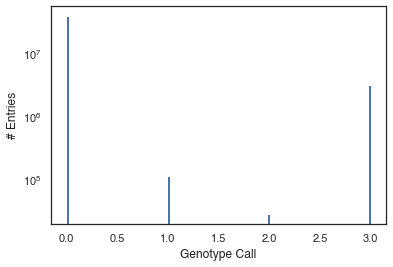

In [6]:
# plot histogram of genotyping values
# genotype call
plt.hist(np.asarray(genotypes).flatten(), bins=100)

plt.yscale('log')

plt.xlabel('Genotype Call')
plt.ylabel('# Entries')

Text(0, 0.5, '# Entries')

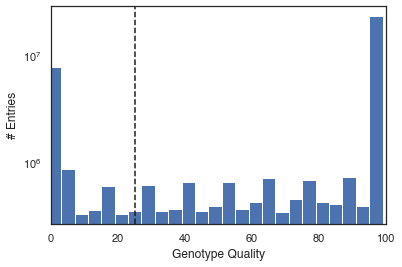

In [7]:
# quality
plt.figure()
plt.hist(np.asarray(quality).flatten(), bins=25)
plt.yscale('log')
plt.xlim([0, 100])
plt.axvline(x=min_quality, color='k', linestyle='--')

plt.xlabel('Genotype Quality')
plt.ylabel('# Entries')

Text(0, 0.5, '# Entries')

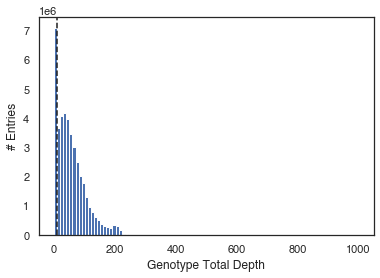

In [8]:
# total depth
plt.figure()
plt.hist(np.asarray(total_depth).flatten(), bins=np.linspace(0, 1000, 100))
plt.axvline(x=min_total_depth, color='k', linestyle='--')
# plt.yscale('log')

plt.xlabel('Genotype Total Depth')
plt.ylabel('# Entries')

Text(0, 0.5, '# Entries')

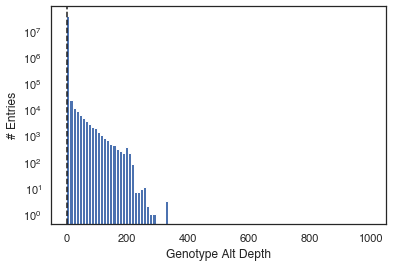

In [9]:
# alt depth
plt.figure()
plt.hist(np.asarray(alt_depth).flatten(), bins=np.linspace(0, 1000, 100))
plt.axvline(x=min_alt_depth, color='k', linestyle='--')
plt.yscale('log')

plt.xlabel('Genotype Alt Depth')
plt.ylabel('# Entries')

### Filter variants

In [10]:
# filter variants for all experiments
# quality and depth
genotypes = filter_variants(genotypes, alt_depth, total_depth, quality, min_alt_depth, min_total_depth, min_quality)

In [11]:
# remove variants genotyped in only a small fraction of cells
number_genotyped = (genotypes != 3).sum(axis=0)
fraction_genotyped = pd.DataFrame(number_genotyped / genotypes.shape[0], columns=['fraction_genotyped'])

In [12]:
# also remove variants mutated in a very small fraction of cells
# fraction mutated is calculated using number genotyped
number_mutated = ((genotypes == 1) | (genotypes == 2)).sum(axis=0)
fraction_mutated = pd.DataFrame(number_mutated.divide(number_genotyped), columns=['fraction_mutated']).dropna()

Text(0, 0.5, '# of variants')

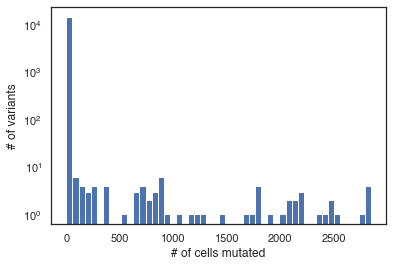

In [13]:
# show variants in many cells
plt.hist(number_mutated, bins=50)
plt.yscale('log')
plt.xlabel('# of cells mutated')
plt.ylabel('# of variants')

In [14]:
# drop variants
genotypes.drop(fraction_genotyped[fraction_genotyped['fraction_genotyped'] < min_fraction_genotyped].index,
               axis=1,
               inplace=True)
genotypes.drop(fraction_mutated[fraction_mutated['fraction_mutated'] < min_fraction_mutated].index,
               axis=1,
               inplace=True,
               errors='ignore')

In [15]:
variants_mutated = [v for v in number_mutated[number_mutated > 100].index if v in genotypes.columns]
print(variants_mutated)

['SF3B1:chr2:198266943:C/T', 'IDH1:chr2:209113048:GA/G', 'IDH1:chr2:209113048:G/GA', ':chr2:209113049:A/*', ':chr2:209113050:A/*', 'KIT:chr4:55599268:C/T', 'KIT:chr4:55599436:T/C', 'LOC101928433-STMND1:chr6:17076799:TAA/T', 'LOC101928433-STMND1:chr6:17076799:TA/T', ':chr6:17076801:A/*', ':chr6:17076802:A/*', 'LOC101928433-STMND1:chr6:17076840:C/A', 'LOC101928433-STMND1:chr6:17076917:ATAAG/A', ':chr6:17076918:TAAGTA/*', ':chr6:17076919:AAGT/*', ':chr6:17076920:AGT/*', ':chr6:17076921:GTAAGTT/*', 'MOCS1-LINC00951:chr6:40116264:T/G', 'EZH2:chr7:148504716:AG/A', ':chr7:148504717:G/*', ':chr7:148504718:GGGGGAGGAGGTAGCAGATGTCAAGGGATTTCCATTTCTCTTTCGATGCCGACATACTTCAGGGCATCAGCCTGGCTGTATCTGAAACAACA/*', 'EZH2:chr7:148504818:A/G', 'EZH2:chr7:148504854:A/AGACTT', 'JAK2:chr9:5073681:CT/C', ':chr9:5073682:T/*', ':chr9:5073683:T/*', 'CALML3-AS1:chr10:5554293:T/C', 'C10orf11:chr10:77210191:C/T', 'C10orf11:chr10:77210229:GA/G', 'C10orf11:chr10:77210229:G/GA', 'SORCS3:chr10:106721610:G/A', 'WT1:chr11:324

In [16]:
genotypes.shape

(2875, 54)

Text(0.5, 1.0, 'Genotyping Calls - Filtered')

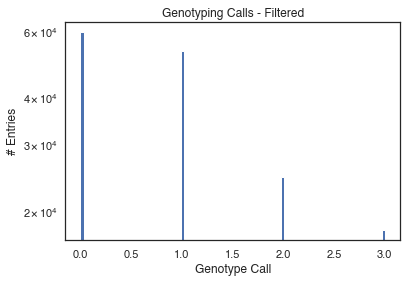

In [17]:
# re-plot genotype calls
plt.hist(np.asarray(genotypes).flatten(), bins=100)
plt.yscale('log')

plt.xlabel('Genotype Call')
plt.ylabel('# Entries')
plt.title('Genotyping Calls - Filtered')

In [18]:
# define specific variants
pathogenic_variants = list(variant_info.index[variant_info['ClinVar_CLNSIG'].astype(str).str.contains('pathogenic', case=False)])
# pathogenic_variants = list(variant_info.index[variant_info['SnpEff_Annotation_Impact'].astype(str).str.contains('MOD', case=False)])

### QC antibody data

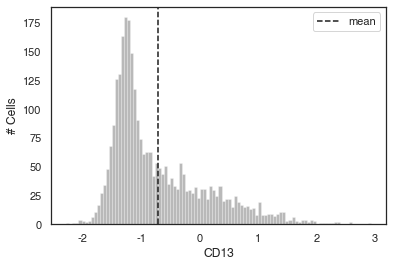

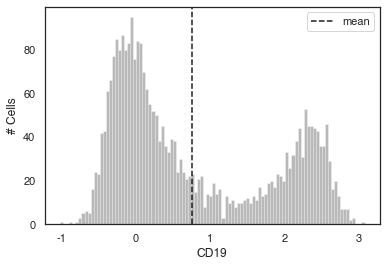

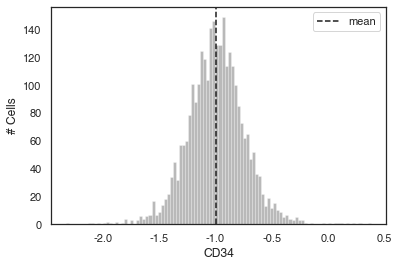

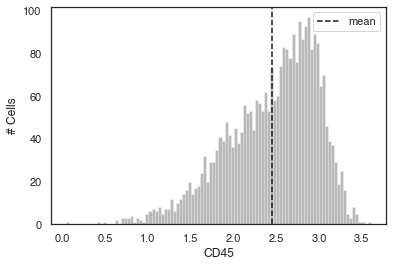

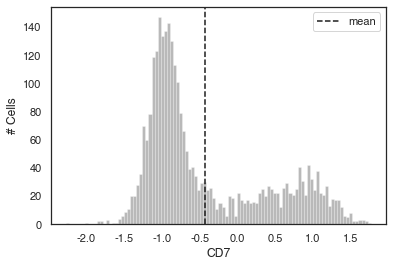

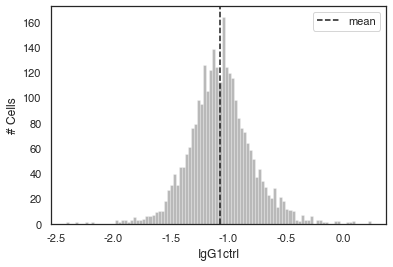

In [19]:
# plot histograms of ab counts
ab_data_to_plot = ab_counts_clr

for c in ab_data_to_plot.columns:
  
    plt.figure(figsize=(6,4))
    
    data = ab_data_to_plot[c]

    plt.hist(data,
             alpha=0.3,
#              bins=np.linspace(-1, 10, 100),
             bins=100,
             color='k')
    plt.axvline(x=np.mean(data), color='k', linestyle='--', label='mean')

    plt.legend()

    plt.xlabel(c)
    plt.ylabel('# Cells')

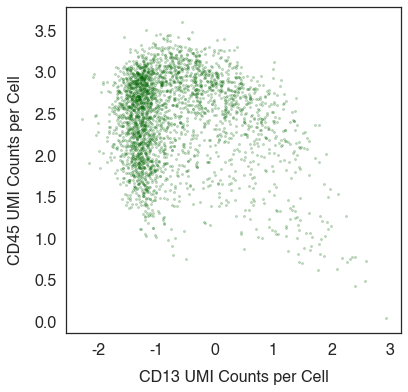

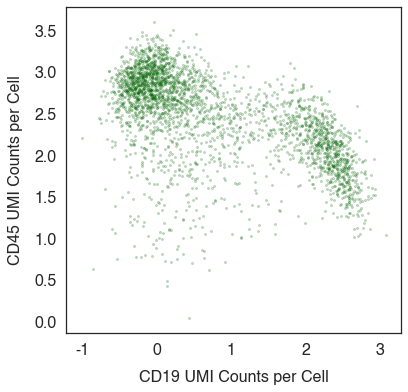

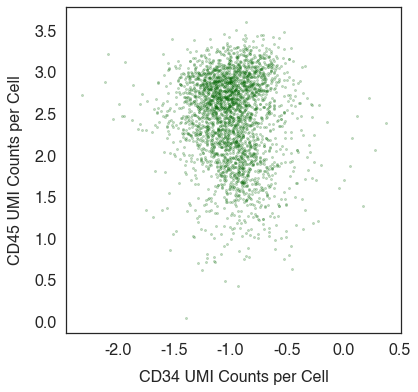

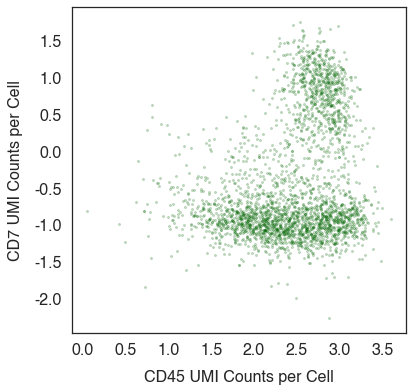

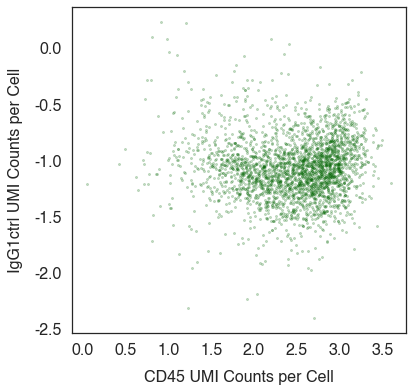

In [20]:
ab_combos = [list(x) for x in itertools.combinations(ab_data_to_plot.columns, 2)]
ab_combos = [c for c in ab_combos if 'CD45' in c[0] or 'CD45' in c[1]]
min_total_count = 100  # minimum sum of all ab counts for a given cell
# ax_min, ax_max = -1, 10

for c in ab_combos:
    plt.figure(figsize=(6, 6))
    
    x = ab_data_to_plot[c[0]]
    y = ab_data_to_plot[c[1]]
    
    plt.scatter(x=ab_data_to_plot[c[0]],
                y=ab_data_to_plot[c[1]],
                alpha=0.2,
                s=4,
                color='darkgreen',
                edgecolor=None)
    
#     plt.gca().set_xscale('log')
#     plt.gca().set_yscale('log')
    
#     plt.xlim(ax_min, ax_max)
#     plt.ylim(ax_min, ax_max)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlabel('%s UMI Counts per Cell' % c[0], fontsize=16, labelpad=12)
    plt.ylabel('%s UMI Counts per Cell' % c[1], fontsize=16, labelpad=12)

In [21]:
ab_combos = [list(x) for x in itertools.combinations(ab_data_to_plot.columns, 2)]
ab_combos = [c for c in ab_combos if 'pERK' in c[0] or 'pERK' in c[1]]
min_total_count = 100  # minimum sum of all ab counts for a given cell
# ax_min, ax_max = -1, 10

for c in ab_combos:
    plt.figure(figsize=(6, 6))
    
    x = ab_data_to_plot[c[0]]
    y = ab_data_to_plot[c[1]]
    
    plt.scatter(x=ab_data_to_plot[c[0]],
                y=ab_data_to_plot[c[1]],
                alpha=0.2,
                s=4,
                color='darkgreen',
                edgecolor=None)
    
#     plt.gca().set_xscale('log')
#     plt.gca().set_yscale('log')
    
#     plt.xlim(ax_min, ax_max)
#     plt.ylim(ax_min, ax_max)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlabel('%s UMI Counts per Cell' % c[0], fontsize=16, labelpad=12)
    plt.ylabel('%s UMI Counts per Cell' % c[1], fontsize=16, labelpad=12)

### Plot UMAP for Ab data

In [22]:
# define data on which to run dimensionality reduction
ab_data = ab_counts_clr
markers = list(ab_data.columns)
data_trans = ab_data.loc[:, [m for m in markers if 'CD45' not in m]]

# umap
trans = umap.UMAP(n_neighbors=50, random_state=42).fit(data_trans)
trans_results = trans.embedding_

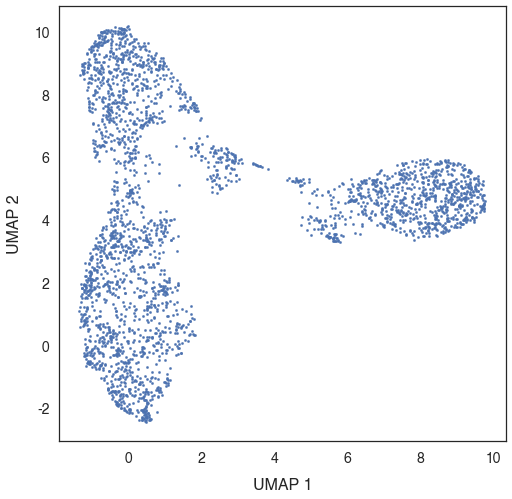

In [23]:
# plot umap
plt.figure(figsize=(8, 8))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.xlabel('tSNE 1', fontsize=14, labelpad=12)
# plt.ylabel('tSNE 2', fontsize=14, labelpad=12)

plt.xlabel('UMAP 1', fontsize=16, labelpad=12)
plt.ylabel('UMAP 2', fontsize=16, labelpad=12)

# sns.set_context('paper')
# sns.set_context('notebook')

reset_matplot()

# sns.scatter(x=trans_results[:, 0],
#             y=trans_results[:, 1],
#             s=5,
#             linewidths=0.5,
#             c=ab_counts_corr['TS-2'],
#             cmap='viridis')

ax = sns.scatterplot(x=trans_results[:, 0],
                     y=trans_results[:, 1],
                     s=6,
                     edgecolor=None)

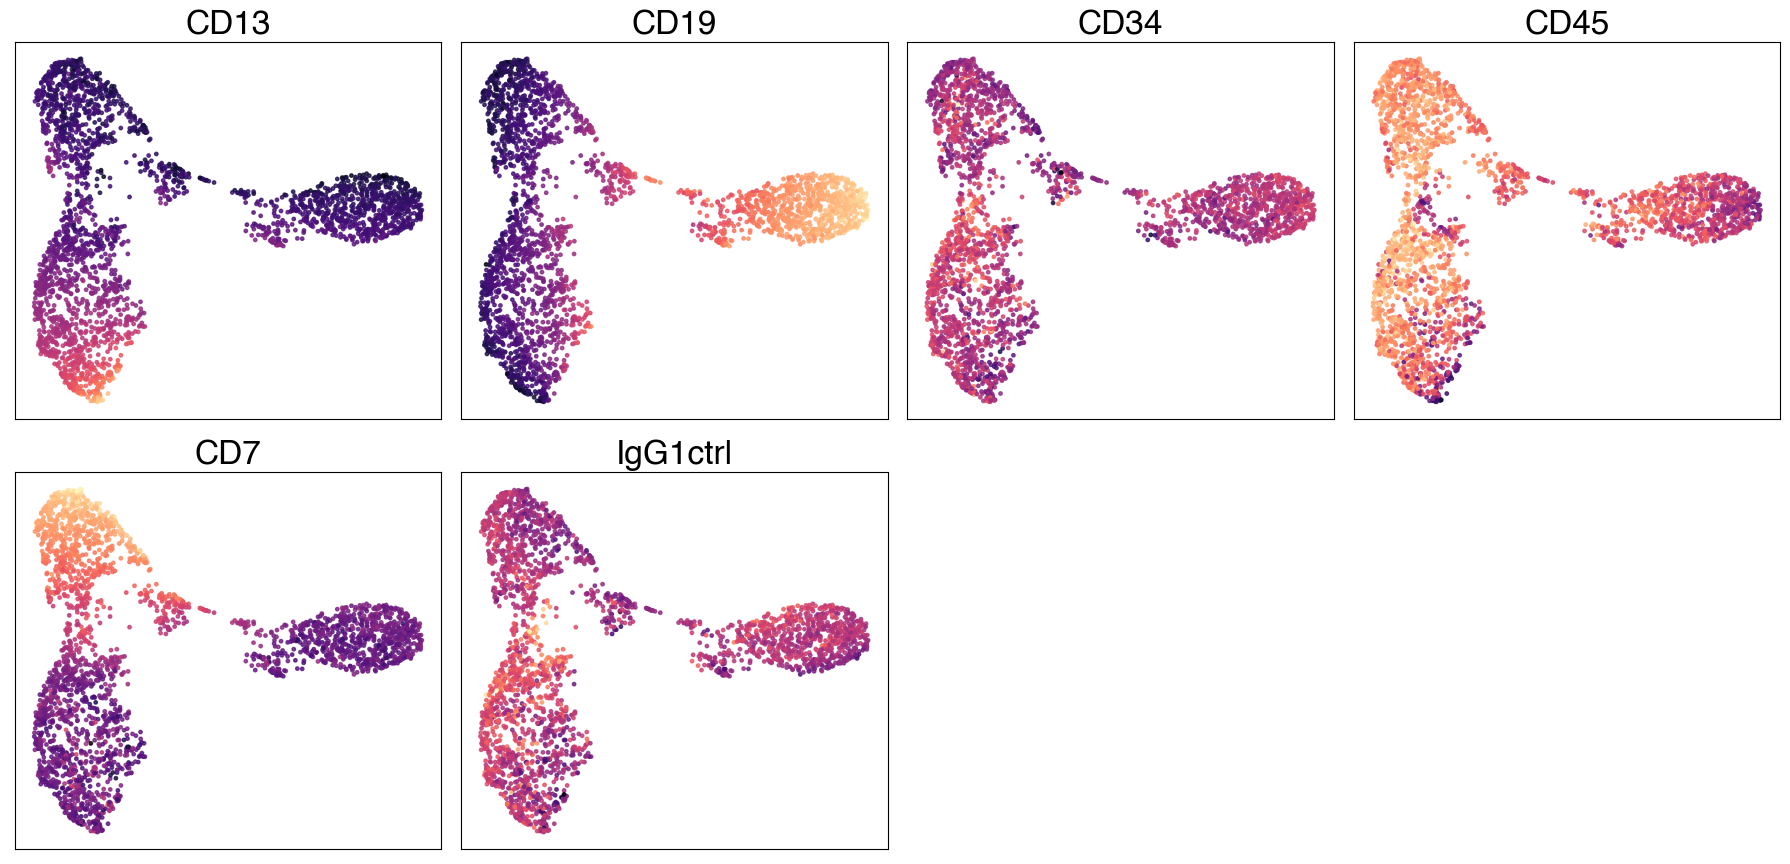

In [24]:
# plot the transform results in an array
fig = plt.figure(figsize=(18, 13))

abs_to_plot = ab_data.columns

for i in range(len(abs_to_plot)):

    ax = fig.add_subplot(3, 4, i + 1)
    ax.scatter(trans_results[:, 0],
               trans_results[:, 1],
               alpha=0.8,
               c=ab_data[abs_to_plot[i]],
               cmap='magma',
#                vmin=0,
#                vmax=5,
               s=6)

    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('0')
    ax.spines['right'].set_color('0')
    ax.spines['left'].set_color('0')

    ax.set_facecolor('w')

    plt.title(abs_to_plot[i].split('_')[0], fontsize=24)

    plt.xticks([])
    plt.yticks([])

#     plt.xlabel('UMAP 1', fontsize=14)
#     plt.ylabel('UMAP 2', fontsize=14)

reset_matplot()
plt.tight_layout()

Text(0, 0.5, 'Total DNA Panel Reads (log10)')

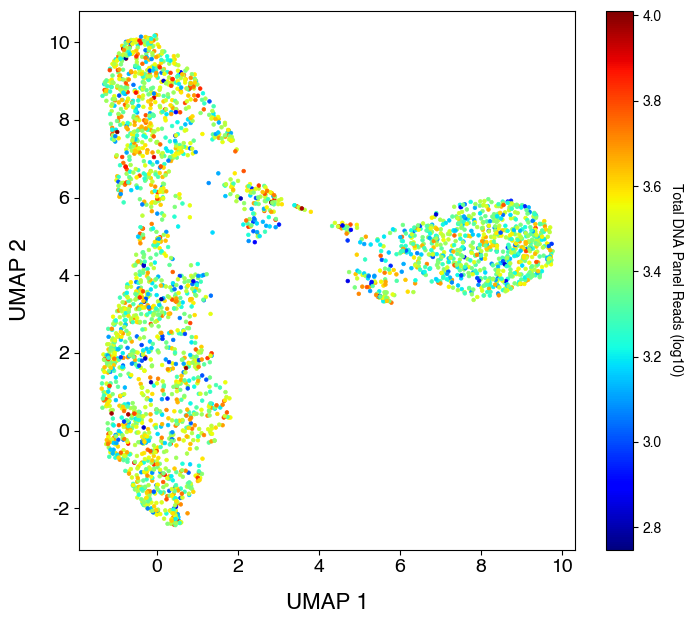

In [25]:
# plot umap
plt.figure(figsize=(8, 7))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.xlabel('tSNE 1', fontsize=14, labelpad=12)
# plt.ylabel('tSNE 2', fontsize=14, labelpad=12)

plt.xlabel('UMAP 1', fontsize=16, labelpad=12)
plt.ylabel('UMAP 2', fontsize=16, labelpad=12)

# sns.set_context('paper')
# sns.set_context('notebook')

reset_matplot()

ax = plt.scatter(x=trans_results[:, 0],
            y=trans_results[:, 1],
            s=7,
            linewidths=0.5,
            c=np.log10(amplicon_counts.sum(axis=1)),
            cmap='jet')

cbar = plt.colorbar()
cbar.ax.set_ylabel('Total DNA Panel Reads (log10)', rotation=270, labelpad=15)

Text(0, 0.5, 'Total Ab Reads (log10)')

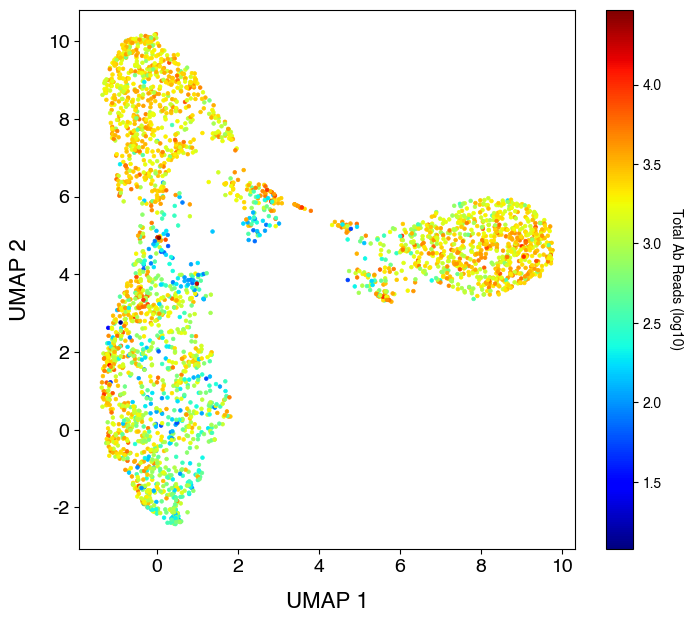

In [26]:
# plot umap
plt.figure(figsize=(8, 7))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.xlabel('tSNE 1', fontsize=14, labelpad=12)
# plt.ylabel('tSNE 2', fontsize=14, labelpad=12)

plt.xlabel('UMAP 1', fontsize=16, labelpad=12)
plt.ylabel('UMAP 2', fontsize=16, labelpad=12)

# sns.set_context('paper')
# sns.set_context('notebook')

reset_matplot()

ax = plt.scatter(x=trans_results[:, 0],
            y=trans_results[:, 1],
            s=7,
            linewidths=0.5,
            c=np.log10(ab_counts_unique.sum(axis=1)),
            cmap='jet')

cbar = plt.colorbar()
cbar.ax.set_ylabel('Total Ab Reads (log10)', rotation=270, labelpad=15)

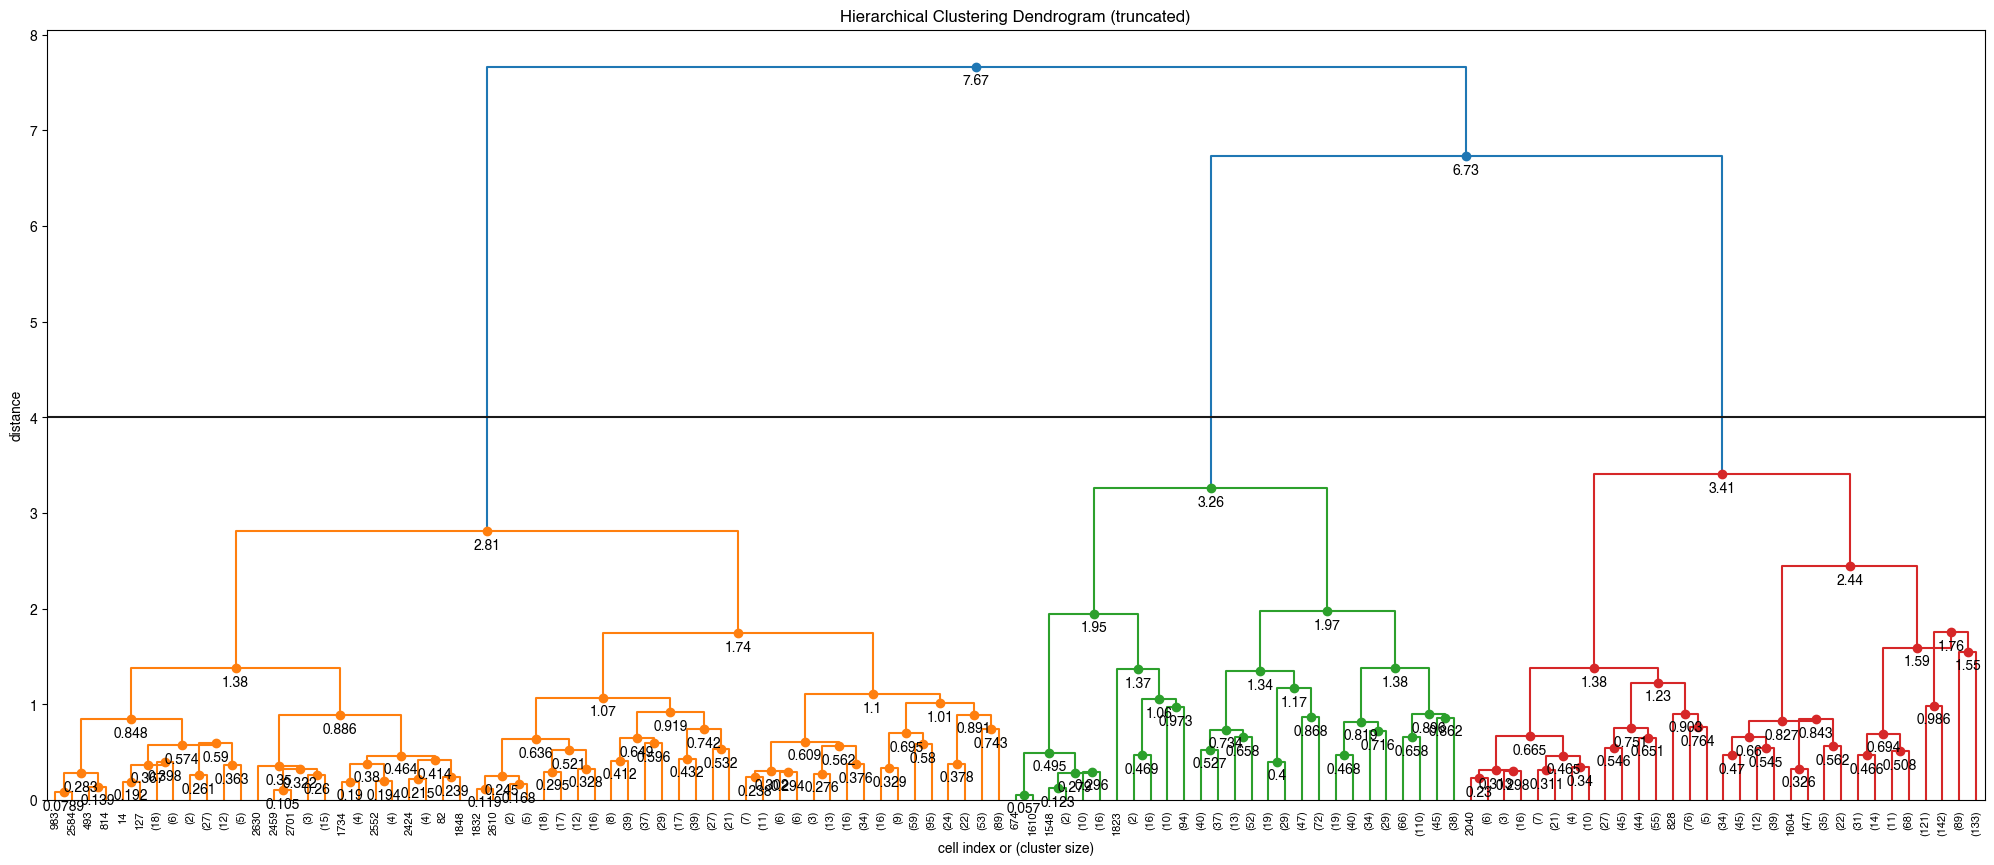

In [34]:
# cluster the cells in UMAP space hierarchically

# generate the linkage matrix
Z = linkage(trans_results, 'centroid')
max_d = 4      # cluster cutoff distance   

# plot dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cell')
plt.ylabel('distance')

# generate dendrogram
fancy_dendrogram(
    Z,
    leaf_rotation=90.,          # rotates the x axis labels
    leaf_font_size=8.,          # font size for the x axis labels
    truncate_mode='level',      # only show last p levels
    p=6,                        # levels to show
    max_d=max_d                 # plot cutoff line
)

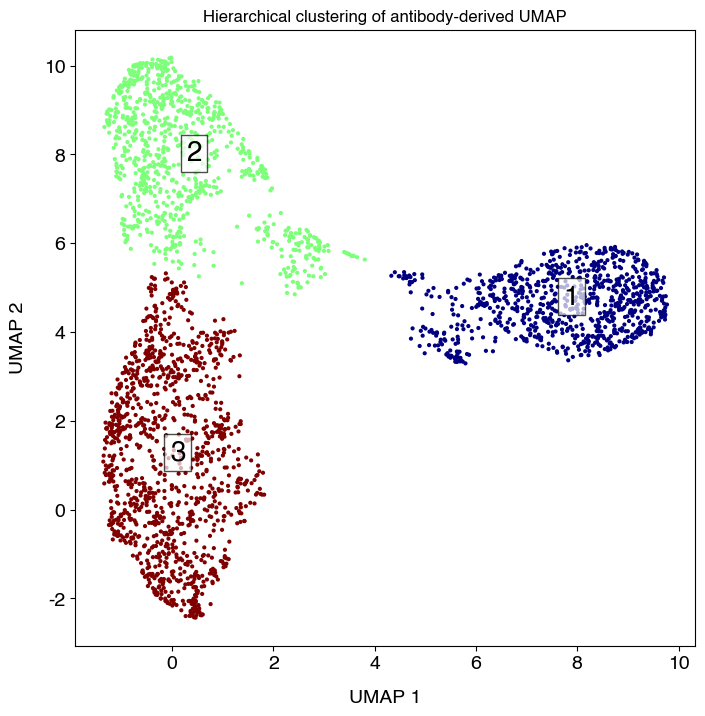

In [35]:
# replot UMAP with cluster overlays

ab_clusters = fcluster(Z, max_d, criterion='distance')     # extract flat clusters

plt.figure(figsize=(8, 8))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('UMAP 1', fontsize=14, labelpad=12)
plt.ylabel('UMAP 2', fontsize=14, labelpad=12)

ab_color = dict(zip(sorted(list(set(ab_clusters))),
                    [plt.cm.get_cmap('jet')(x) for x in np.linspace(0, 1, len(set(ab_clusters)))]))

c = [ab_color[c] for c in ab_clusters]
  
plt.scatter(trans_results[:, 0],
            trans_results[:, 1], 
            c=c,
            s=4,
            edgecolor=None)

plt.title('Hierarchical clustering of antibody-derived UMAP')

# add cluster labels to graph
for cl in set(ab_clusters):
    pts = [ind for ind in range(len(ab_clusters)) if ab_clusters[ind] == cl]      # find cells in this cluster
    x_vals = [trans_results[i, 0] for i in pts]
    y_vals = [trans_results[i, 1] for i in pts]
    center = (np.mean(x_vals), np.mean(y_vals))     # calculate center
    t = plt.annotate(str(cl), xy=center, fontsize=20)
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor=None))

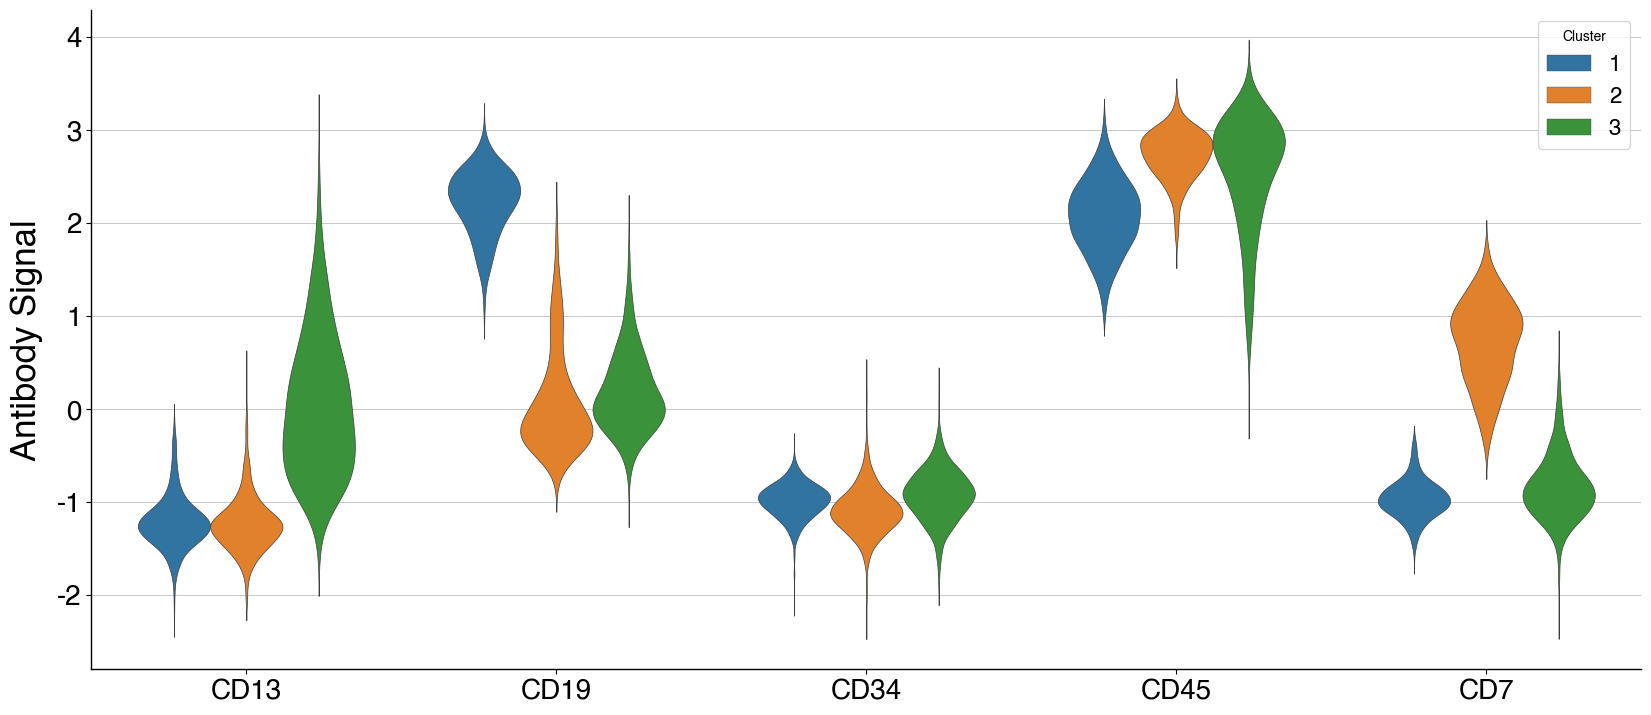

In [40]:
# plot expression by cluster

cluster_data = ab_data
cluster_data['Cluster'] = ab_clusters
cluster_data['Cluster'] = cluster_data['Cluster'].astype(str)

markers = ab_data.columns

data = pd.melt(cluster_data,
               id_vars=['Cluster'],
               value_vars=[m for m in markers if 'CD' in m])

sns.set_style('white')
reset_matplot()

plt.figure(figsize=(20, 10))

ax = sns.violinplot(data=data,
                    x='variable',
                    y='value',
                    hue='Cluster',
                    bw=0.3,
                    width=0.7,
                    showfliers=False,
                    inner=None,
                    linewidth=0.5,
                    scale='width')

plt.xlabel('')
plt.ylabel('Antibody Signal', fontsize=25, labelpad=40)

ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 15

# plt.xticks(rotation=90, fontsize=30)
# plt.yticks(rotation=90, fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

ax.set_aspect(0.3)

plt.gca().yaxis.grid(linewidth=0.5)

plt.gca().set_axisbelow(True)

ax.get_legend().remove()

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

plt.legend(title='Cluster', fontsize=16)

In [29]:
# define pathogenic variants
# pathogenic_variants = list(variant_info.index[variant_info['ClinVar_CLNSIG'].astype(str).str.contains('pathogenic', case=False)])
pathogenic_variants = list(variant_info.index[variant_info['SnpEff_Annotation_Impact'].astype(str).str.contains('MOD', case=False)])

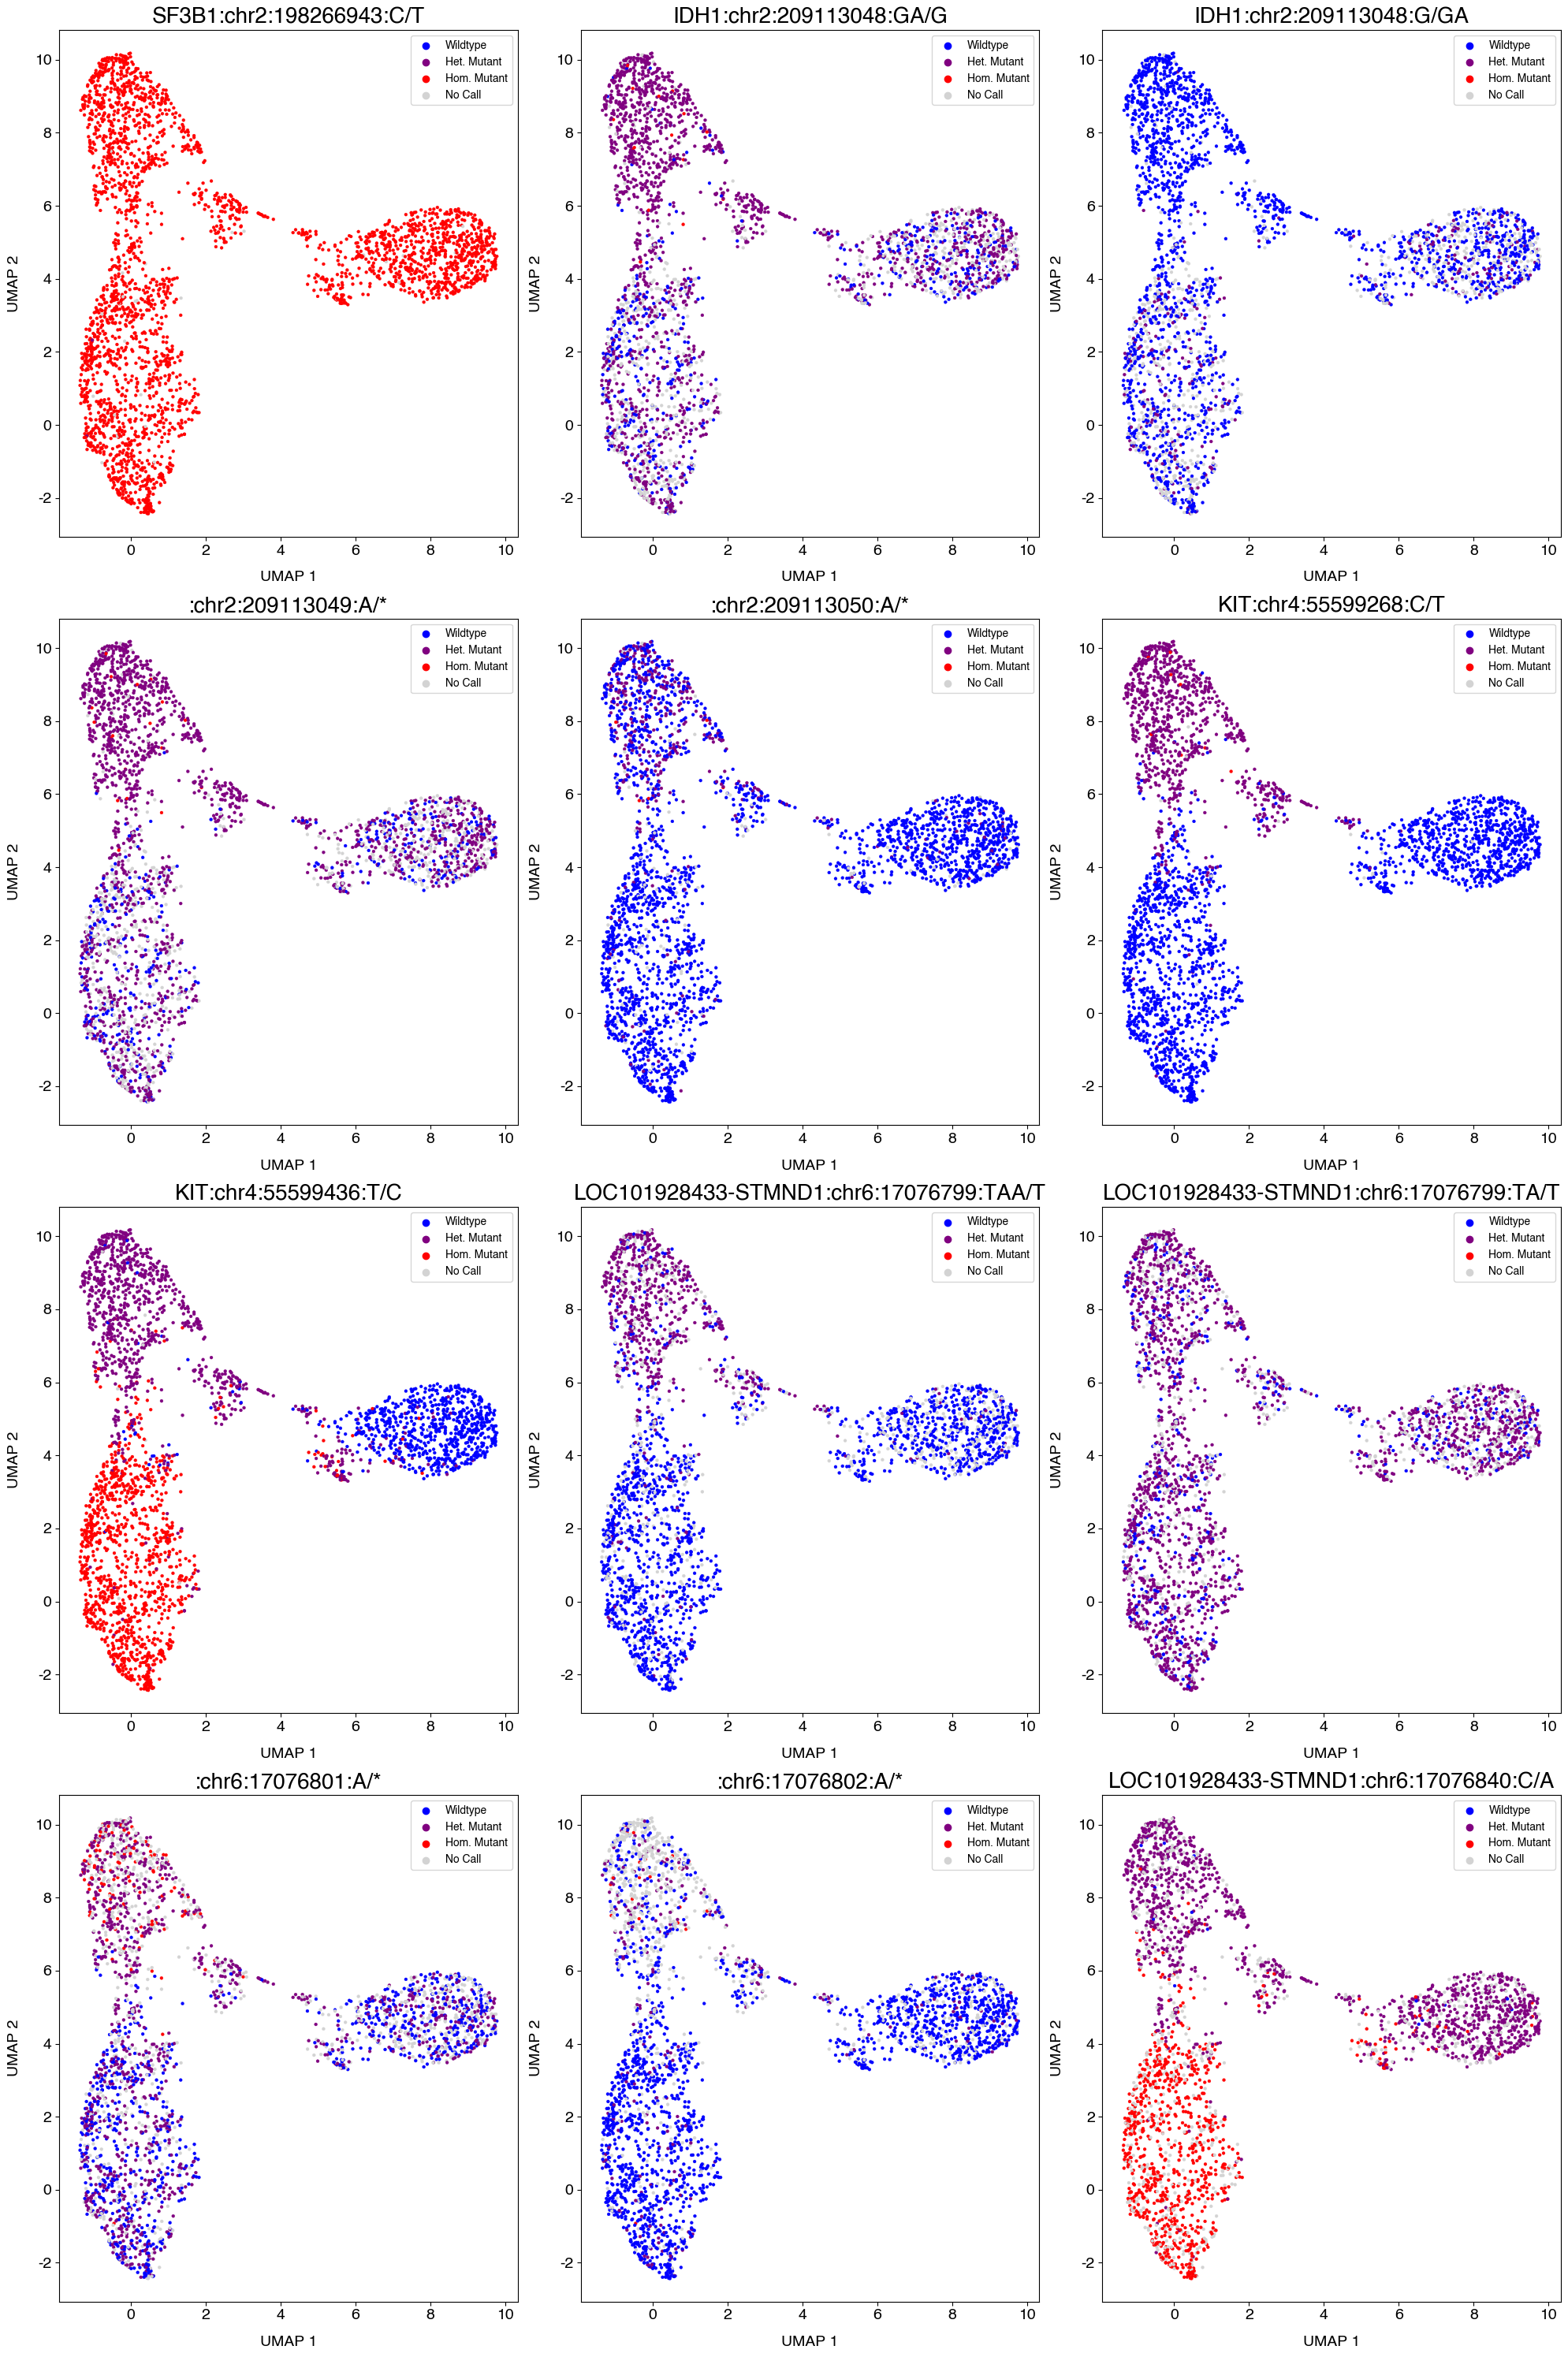

In [32]:
# overlay umap with genotyping calls from selected variants

# variants_to_plot = list(genotypes.loc[:, [c for c in genotypes.columns if c in pathogenic_variants]].columns)
# variants_to_plot = list(genotypes.loc[:, [c for c in genotypes.columns if c in variants_mutated]].columns)
variants_to_plot = genotypes.columns
# variants_to_plot = variants_mutated

plt.figure(figsize=(20, 30))

for i in range(len(variants_to_plot))[:12]:

    v = variants_to_plot[i]
    
    ax = plt.subplot(4, 3, i + 1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel('UMAP 1', fontsize=14, labelpad=12)
    plt.ylabel('UMAP 2', fontsize=14, labelpad=12)
    
    plt.title(v, fontsize=20)

    hue_map = {0: 'Wildtype',
               1: 'Het. Mutant',
               2: 'Hom. Mutant',
               3: 'No Call'}
    
    color_map = {'Wildtype': 'blue',
                 'Het. Mutant': 'purple',
                 'Hom. Mutant': 'red',
                 'No Call': 'lightgrey'}

    sns.scatterplot(x=trans_results[:, 0],
                    y=trans_results[:, 1], 
                    hue=[hue_map[g] for g in genotypes.loc[:, v]],
                    palette=color_map,
                    hue_order=['Wildtype', 'Het. Mutant', 'Hom. Mutant', 'No Call'],
                    s=8,
                    edgecolor=None)

    ax.legend(fontsize=10)
    plt.tight_layout()

Text(0.5, 1.0, 'TP53:chr17:7578263:G/A')

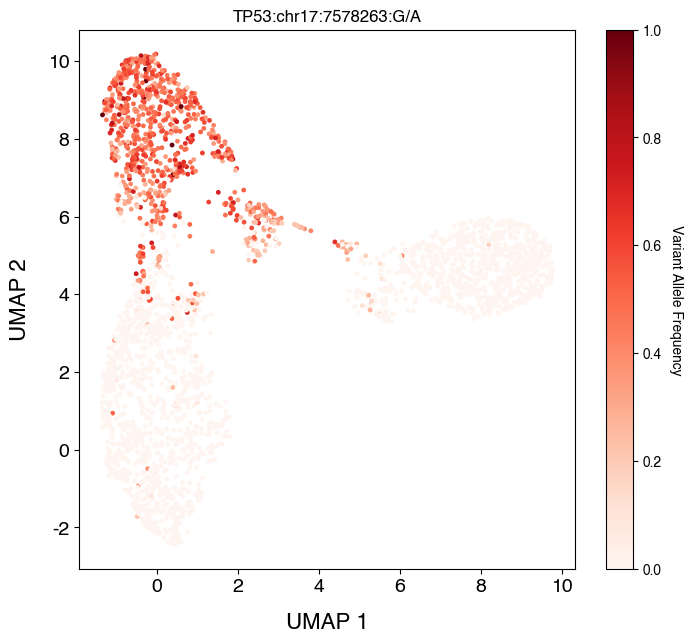

In [33]:
# plot umap with vaf

# variant = 'WT1:chr11:32417886:C/T'
# variant = 'RUNX1:chr21:36252917:C/T'
# variant = 'U2AF1:chr21:44524290:A/C'
# variant = 'KIT:chr4:55599232:A/C'
# variant = 'DNMT3A:chr2:25457351:C/A'
# variant = 'PTPN11:chr12:112927042:T/A'
variant = 'TP53:chr17:7578263:G/A'
# variant = 'U2AF1:chr21:44524406:G/A'

# plot umap
plt.figure(figsize=(8, 7))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.xlabel('tSNE 1', fontsize=14, labelpad=12)
# plt.ylabel('tSNE 2', fontsize=14, labelpad=12)

plt.xlabel('UMAP 1', fontsize=16, labelpad=12)
plt.ylabel('UMAP 2', fontsize=16, labelpad=12)

# sns.set_context('paper')
# sns.set_context('notebook')

reset_matplot()

ax = plt.scatter(x=trans_results[:, 0],
                 y=trans_results[:, 1],
                 s=12,
                 linewidths=0,
                 c=vaf.loc[:, variant],
                 vmax=1,
                 vmin=0,
                 cmap='Reds')

cbar = plt.colorbar()
cbar.ax.set_ylabel('Variant Allele Frequency', rotation=270, labelpad=15)
plt.title(variant)